In [11]:
import pandas as pd
import numpy as np
import os 

# Define helper
def get_path(*parts):
    return os.path.join('..', *parts)

# Load input data
df_emp   = pd.read_csv(get_path('Data', 'employment_ratio.csv'))
df_gdp   = pd.read_csv(get_path('Data', 'gdp_per_capita_ppp.csv'))
df_labsh = pd.read_csv(get_path('Data', 'pwt_labor_share_extended.csv'))
df_hours = pd.read_csv(get_path('Result', 'Hours_extrapolated_1990_2023_selected.csv'))



# --- 2. NORMALIZE COLUMN NAMES ---
df_emp.columns = df_emp.columns.str.strip().str.lower()
df_gdp.columns = df_gdp.columns.str.strip().str.lower()
df_labsh.columns = df_labsh.columns.str.strip().str.lower()
df_hours.columns = df_hours.columns.str.strip().str.lower()

print("EMP columns:", df_emp.columns.tolist())
print("GDP columns:", df_gdp.columns.tolist())
print("LABSH columns:", df_labsh.columns.tolist())
print("HOURS columns:", df_hours.columns.tolist())  # Check how the working hours file is structured

# --- 3. MELT (UNPIVOT) THE WIDE DATAFRAMES ---
# For Employment ratio & GDP, we assume: "country code", "country", "series name", plus year columns.
df_emp_melt = df_emp.melt(
    id_vars=["country code", "country", "series name"],
    var_name="year",
    value_name="empratio"
)

df_gdp_melt = df_gdp.melt(
    id_vars=["country code", "country", "series name"],
    var_name="year",
    value_name="gdpcap"
)

# For Labor share (PWT), we assume: "iso code", "country", "variable code", "variable name"
df_labsh_melt = df_labsh.melt(
    id_vars=["iso code", "country", "variable code", "variable name"],
    var_name="year",
    value_name="laborshare"
)

# For Penn working hours, from your screenshot:
# "Country" in first column, then columns for each year (1990, 1991, ...)
df_hours_melt = df_hours.melt(
    id_vars=["country"],      # keep "country" fixed
    var_name="year",          # melted columns become "year"
    value_name="whours"       # melted values become "whours"
)

# --- 4. RENAME / ALIGN COLUMNS FOR CONSISTENCY ---
df_emp_melt.rename(columns={"country code": "wb_countrycode"}, inplace=True)
df_gdp_melt.rename(columns={"country code": "wb_countrycode"}, inplace=True)
df_labsh_melt.rename(columns={"iso code": "iso_code"}, inplace=True)
# For hours, if you have a separate ISO code or if you rely on "country" only,
# you might later need to do name matching or rename "country" to "iso_code".
# For simplicity, let's assume we match on "country" + "year".

# --- 5. CREATE A COMMON MERGE KEY ---
df_emp_melt["iso_code"] = df_emp_melt["wb_countrycode"]
df_gdp_melt["iso_code"] = df_gdp_melt["wb_countrycode"]

# Convert "year" columns to numeric
for df_ in [df_emp_melt, df_gdp_melt, df_labsh_melt, df_hours_melt]:
    df_["year"] = pd.to_numeric(df_["year"], errors="coerce")

# --- 6. MERGE EMP + GDP + LABOR SHARE ---
df_merged_1 = pd.merge(
    df_emp_melt[["iso_code", "country", "year", "empratio"]],
    df_gdp_melt[["iso_code", "country", "year", "gdpcap"]],
    on=["iso_code", "year"],
    how="outer"
)

df_merged = pd.merge(
    df_merged_1,
    df_labsh_melt[["iso_code", "year", "laborshare"]],
    on=["iso_code", "year"],
    how="outer"
)

# --- 7. CONVERT TO NUMERIC (if not already) ---
df_merged["empratio"]   = pd.to_numeric(df_merged["empratio"], errors="coerce")
df_merged["gdpcap"]     = pd.to_numeric(df_merged["gdpcap"], errors="coerce")
df_merged["laborshare"] = pd.to_numeric(df_merged["laborshare"], errors="coerce")

# >>>>> INSERTED CODE: Unify country columns <<<<<
# Rename one of the duplicate country columns to "country" and drop the other
df_merged.rename(columns={"country_x": "country"}, inplace=True)
if "country_y" in df_merged.columns:
    df_merged.drop(columns=["country_y"], inplace=True)
# -----------------------------------------------------

# --- 8. MERGE WORKING HOURS ---
# Merge on "country" + "year"
df_final = pd.merge(
    df_merged,
    df_hours_melt[["country", "year", "whours"]],
    on=["country", "year"],
    how="inner"  # or "outer" if you want to keep all rows and then filter missing
)

# --- 9. FILTER OUT ROWS THAT LACK ANY COMPONENT (we only want complete data) ---
df_final = df_final.dropna(subset=["empratio", "gdpcap", "laborshare", "whours"])


# --- 10. COMPUTE LOG-COMPONENTS AND FINAL y_{i,t} ---

# convert employment ratio (%) into a fraction
df_final['empratio_frac'] = df_final['empratio'] / 100.0

# take logs of each component
df_final['ln_g'] = np.log(df_final['gdpcap'])            # ln GDP per cap (PPP)
df_final['ln_l'] = np.log(df_final['laborshare'])       # ln labor share
df_final['ln_e'] = np.log(df_final['empratio_frac'])    # ln employment/population
df_final['ln_h'] = np.log(df_final['whours'])           # ln hours worked

# build the log-wage series as the sum/difference of logs
df_final['y'] = (
    df_final['ln_g']
  + df_final['ln_l']
  - df_final['ln_e']
  - df_final['ln_h']
)

# remove any infinite or missing values created by logs
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.dropna(subset=['y'], inplace=True)


# --- 11. EXPORT RESULTS ---
output_file = get_path('Result', 'Countries_Wages_Estimates_GOOD_Split.csv')
df_final["year"] = df_final["year"].astype(int)
df_final.to_csv(output_file, index=False)
print(f"Done! '{output_file}' created with 'estimated_hourly_wage' and its log-transformation.")

# 12. LOAD OECD BENCHMARK

df_oecd = pd.read_csv(get_path('Data', 'OECD_wages_merged.csv'))
df_oecd.rename(columns={'Country':'country','Wages':'oecd_annual_wage','Year':'year'}, inplace=True)
df_oecd['year'] = pd.to_numeric(df_oecd['year'], errors='coerce')

# 13. MERGE INTO df_compare
df_compare = pd.merge(
    df_final,
    df_oecd[['country','year','oecd_annual_wage']],
    on=['country','year'],
    how='inner'
)

# 14. COMPUTE OECD HOURLY WAGE
df_compare['oecd_hourly_wage'] = df_compare['oecd_annual_wage'] / df_compare['whours']

# Now df_compare is available for groupbys and plotting
print("df_compare created with", len(df_compare), "rows")

EMP columns: ['country', 'country code', 'series name', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'unnamed: 36', 'unnamed: 37', 'unnamed: 38']
GDP columns: ['country', 'country code', 'series name', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'unnamed: 36', 'unnamed: 37']
LABSH columns: ['iso code', 'country', 'variable code', 'variable name', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '201

Norway calibration (y_oecd ~ y):
  Intercept: -2.903
  Slope    : 1.728
Exported Norway data to ../Result/norway_data.csv
Plot saved to ../Result/Plots/Norway_LogWage_Oil.pdf


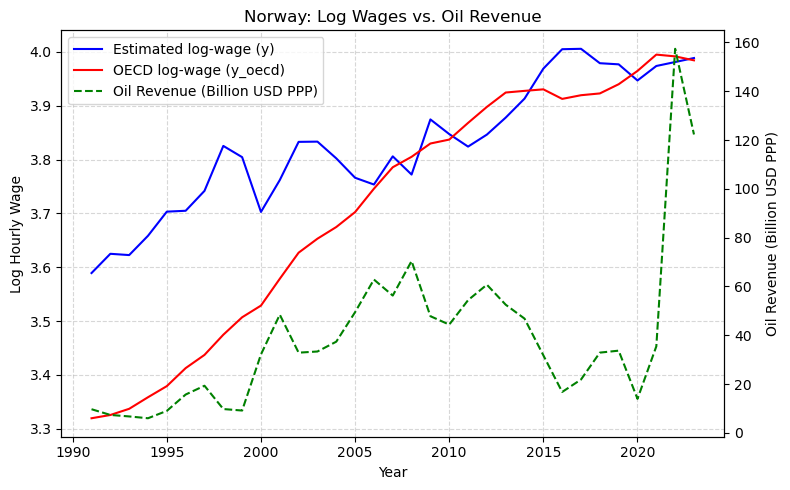

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. Load the UPDATED log‐wage panel (with Norway’s oil‐adjusted y)
logs_path = get_path('Result', 'Countries_Wages_Estimates_GOOD_Split.csv')

df_logs = pd.read_csv(logs_path)

# 2. Load OECD annual‐wage data and prepare it
oecd_path = get_path('Data', 'OECD_wages_merged.csv')

df_oecd = pd.read_csv(oecd_path)
df_oecd.rename(columns={
    'Country': 'country',
    'Wages':   'oecd_annual_wage',
    'Year':    'year'
}, inplace=True)
df_oecd['year'] = pd.to_numeric(df_oecd['year'], errors='coerce')

# 3. Merge your log series with OECD annual wages, then compute OECD log‐hourly wage
df_base = (
    df_logs[['country','year','y','whours']]
      .merge(df_oecd[['country','year','oecd_annual_wage']],
             on=['country','year'], how='inner')
)
df_base['y_oecd'] = np.log(df_base['oecd_annual_wage'] / df_base['whours'])

# 4. Subset to Norway and drop any missing values
df_norway = (
    df_base[df_base['country']=='Norway']
      .dropna(subset=['y','y_oecd'])
      .sort_values('year')
)

if len(df_norway) < 2:
    raise ValueError("Not enough Norway data for regression/plot")

# 5. Run the simple calibration regression: y_oecd ~ y
X = df_norway[['y']].values
y_true = df_norway['y_oecd'].values
model = LinearRegression().fit(X, y_true)
print("Norway calibration (y_oecd ~ y):")
print(f"  Intercept: {model.intercept_:.3f}")
print(f"  Slope    : {model.coef_[0]:.3f}")



# 6. Load Norwegian oil revenue and merge
df_oil = pd.read_excel(
    get_path('Data', 'Norwegian_Oil_revenue.xlsx'),
    sheet_name='Noe'
).rename(columns={
    'Year': 'year',
    'NCF converted in PPP': 'oil_revenue_billion_usd'
})

# Ensure 'year' is numeric
df_oil['year'] = pd.to_numeric(df_oil['year'], errors='coerce')

# Merge oil revenue data into Norway-specific wage data
df_norway = df_norway.merge(
    df_oil[['year', 'oil_revenue_billion_usd']],
    on='year',
    how='inner'
)



# 7. Export Norway data for LaTeX or further analysis
export_path = get_path('Result', 'norway_data.csv')
df_norway[['year','y','y_oecd','oil_revenue_billion_usd']]\
    .to_csv(export_path, index=False)
print(f"Exported Norway data to {export_path}")

# 8. Plot dual‐axis: estimated vs OECD log‐wages and oil revenue
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(df_norway['year'], df_norway['y'],      color='blue',  label='Estimated log‐wage (y)')
ax1.plot(df_norway['year'], df_norway['y_oecd'], color='red',   label='OECD log‐wage (y_oecd)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Log Hourly Wage')
ax1.set_title('Norway: Log Wages vs. Oil Revenue')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(
    df_norway['year'],
    df_norway['oil_revenue_billion_usd'],
    color='green',
    linestyle='--',
    label='Oil Revenue (Billion USD PPP)'
)
ax2.set_ylabel('Oil Revenue (Billion USD PPP)')

# Combine legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='best')

plt.tight_layout()

# 9. Save the plot
plot_path = get_path('Result', 'Plots', 'Norway_LogWage_Oil.pdf')

os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path, dpi=300)
print(f"Plot saved to {plot_path}")
plt.show()


Oil-adjusted regression (log scale):
  α (intercept)            = -45.505
  β_year                   = 0.025
  β_estimated log-wage (y) = -0.133
  β_oil_revenue            = 0.000

MSE before oil-adj: 0.0310
MSE after  oil-adj: 0.0025
Oil adjustment improves fit.
📄 Plot saved to: ../Result/Plots/Norway_LogWage_Oil_Adjusted_Comparison.pdf


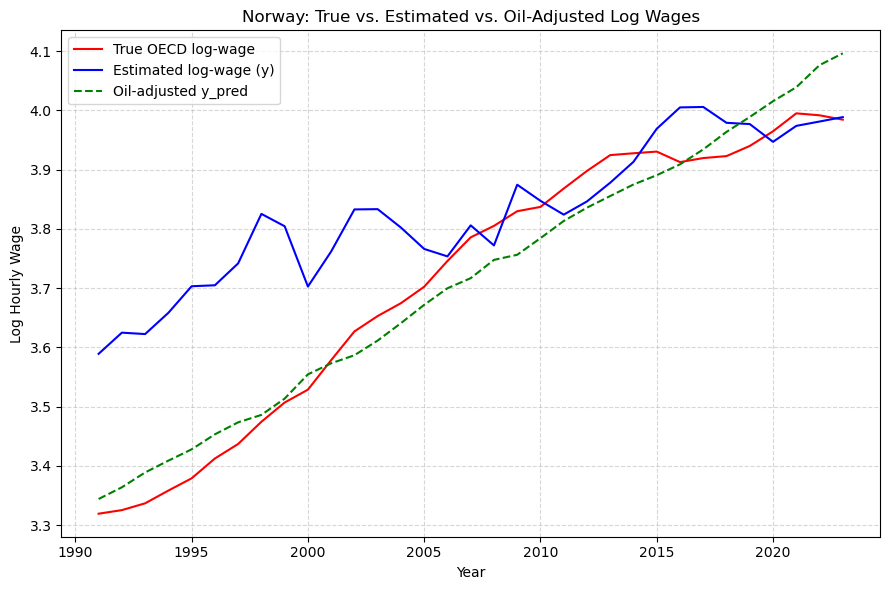


OLS calibration summary (y_oecd ~ y):
                            OLS Regression Results                            
Dep. Variable:                 y_oecd   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     130.0
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           1.28e-12
Time:                        16:39:43   Log-Likelihood:                 29.042
No. Observations:                  33   AIC:                            -54.08
Df Residuals:                      31   BIC:                            -51.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# ——————————————————————————————————————————————————————————————————————
# Assume `df_norway` is already defined and has:
#    ['country','year','y','y_oecd','oil_revenue_billion_usd']
# ——————————————————————————————————————————————————————————————————————

# 1. Drop any rows missing key variables
df_norway_model = df_norway.dropna(
    subset=['y','y_oecd','oil_revenue_billion_usd']
).copy()

if len(df_norway_model) < 5:
    raise ValueError("Not enough Norway data for the oil-adjustment regression.")

# 2. Fit the oil-adjusted log-wage regression:
#      y_oecd = α + β1·year + β2·y + β3·oil_revenue + ε
X = df_norway_model[['year','y','oil_revenue_billion_usd']]
y_true = df_norway_model['y_oecd']
linreg = LinearRegression().fit(X, y_true)

# 3. Print coefficients
α = linreg.intercept_
β_year, β_y, β_oil = linreg.coef_
print("Oil-adjusted regression (log scale):")
print(f"  α (intercept)            = {α:.3f}")
print(f"  β_year                   = {β_year:.3f}")
print(f"  β_estimated log-wage (y) = {β_y:.3f}")
print(f"  β_oil_revenue            = {β_oil:.3f}")

# 4. Compute fitted values & MSE on log scale
df_norway_model['y_pred'] = linreg.predict(X)
mse_before = np.mean((df_norway_model['y']     - df_norway_model['y_oecd'])**2)
mse_after  = np.mean((df_norway_model['y_pred'] - df_norway_model['y_oecd'])**2)
print(f"\nMSE before oil-adj: {mse_before:.4f}")
print(f"MSE after  oil-adj: {mse_after:.4f}")
print("Oil adjustment",
      "improves fit." if mse_after < mse_before else "does not improve fit.")

# 5. Plot true vs. estimated vs. oil-adjusted (all in logs)
plt.figure(figsize=(9,6))
plt.plot(df_norway_model['year'], df_norway_model['y_oecd'],
         color='red',   label='True OECD log-wage')
plt.plot(df_norway_model['year'], df_norway_model['y'],
         color='blue',  label='Estimated log-wage (y)')
plt.plot(df_norway_model['year'], df_norway_model['y_pred'],
         color='green', linestyle='--', label='Oil-adjusted y_pred')
plt.xlabel('Year')
plt.ylabel('Log Hourly Wage')
plt.title('Norway: True vs. Estimated vs. Oil-Adjusted Log Wages')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Define the relative output path
out_pdf = os.path.join('..', 'Result', 'Plots', 'Norway_LogWage_Oil_Adjusted_Comparison.pdf')

# Ensure the directory exists
os.makedirs(os.path.dirname(out_pdf), exist_ok=True)

# Save the plot
plt.savefig(out_pdf, dpi=300)
print(f"📄 Plot saved to: {out_pdf}")
plt.show()

# 6. “Calibration” via simple OLS of y_oecd on y
X_sm = sm.add_constant(df_norway_model['y'])
ols = sm.OLS(df_norway_model['y_oecd'], X_sm).fit()
print("\nOLS calibration summary (y_oecd ~ y):")
print(ols.summary())
print("Residual MSE:", ols.mse_resid)


In [33]:
import os
import pandas as pd

# 1. Load the existing log‐wage panel

infile = os.path.join('..', 'Result', 'Countries_Wages_Estimates_GOOD_Split.csv')
df_final = pd.read_csv(infile)

# 2. Extract Norway’s new oil‐adjusted log‐wage predictions
#    (assumes df_norway_model with cols ['year','y_pred'] is in memory)
df_norway_new = df_norway_model[['year', 'y_pred']]

# 3. Merge to align years, then overwrite Norway’s y
#    (we keep only the order of Norway rows for assignment)
df_norway_old = df_final[df_final['country']=='Norway']
df_norway_upd = df_norway_old.merge(df_norway_new, on='year', how='left')

# 4. Assign back into df_final
mask = df_final['country']=='Norway'
df_final.loc[mask, 'y'] = df_norway_upd['y_pred'].values


# 5. Save the updated panel
outfile = os.path.join('..', 'Result', 'Countries_Wages_Estimates_Finals_GOOD_Split.csv')
df_final.to_csv(outfile, index=False)
print(f"✅ Updated log-wage panel saved to: {outfile}")



✅ Updated log-wage panel saved to: ../Result/Countries_Wages_Estimates_Finals_GOOD_Split.csv


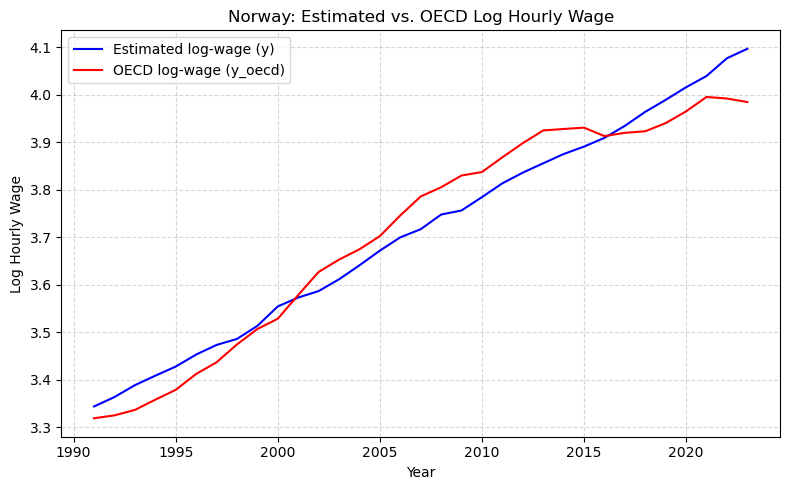

In [37]:


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. Load your split log-wage panel (replace with your actual path)
df_logs = pd.read_csv(get_path('Result', 'Countries_Wages_Estimates_Finals_GOOD_Split.csv'))


# 2. Load OECD data and compute y_oecd
oecd_path = get_path('Data', 'OECD_wages_merged.csv')
df_oecd = pd.read_csv(oecd_path)
df_oecd.rename(columns={'Country':'country','Wages':'oecd_annual_wage','Year':'year'}, inplace=True)
df_oecd['year'] = pd.to_numeric(df_oecd['year'], errors='coerce')

# Pull Norway's working hours from df_logs
nor_whours = df_logs[df_logs['country']=='Norway'][['year','whours']]

# Merge to get Norway’s OECD series with the correct hours
df_oecd_nor = pd.merge(
    df_oecd[df_oecd['country']=='Norway'],
    nor_whours,
    on='year',
    how='inner'
)
df_oecd_nor['y_oecd'] = np.log(df_oecd_nor['oecd_annual_wage'] / df_oecd_nor['whours'])

# 3. Extract Norway’s estimated log-wage
df_nor_est = df_logs[df_logs['country']=='Norway'][['year','y']]

# 4. Merge the two series by year
df_norway = pd.merge(
    df_nor_est,
    df_oecd_nor[['year','y_oecd']],
    on='year'
).sort_values('year')

# 5. Plot both on the log scale
plt.figure(figsize=(8,5))
plt.plot(df_norway['year'], df_norway['y'],      label='Estimated log-wage (y)', color='blue')
plt.plot(df_norway['year'], df_norway['y_oecd'], label='OECD log-wage (y_oecd)', color='red')
plt.xlabel('Year')
plt.ylabel('Log Hourly Wage')
plt.title('Norway: Estimated vs. OECD Log Hourly Wage')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Second Part

Scenarios saved to ../Result/OECD_benchmark_scenarios_Split.csv
Plot saved to ../Result/Plots/OECD_benchmark_scenarios_Split.pdf


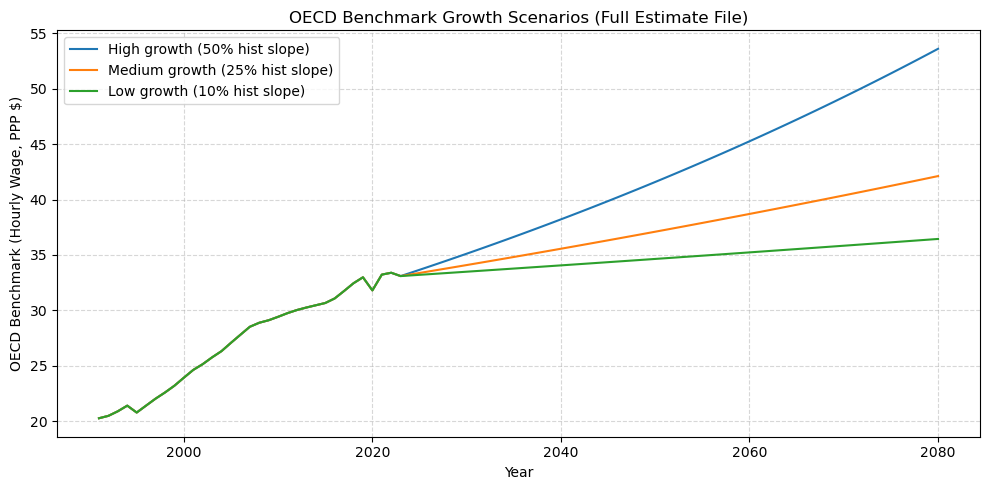

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ================================================
# 1. LOAD YOUR FULL ESTIMATE FILE AND LOG-TRANSFORM
# ================================================
full_path = get_path('Data', 'Countries_Wages_Estimates_Finals_GOOD.csv')
df = pd.read_csv(full_path)
df['log_wage'] = np.log(df['estimated_hourly_wage'])

# ================================================
# 2. DEFINE THE “RICH‐OECD” BENCHMARK COUNTRIES
# ================================================
oecd_rich = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Rep.','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Estonia','Korea','Lithuania','Poland'
}

# ================================================
# 3. COMPUTE HISTORICAL BENCHMARK LOG SERIES
#    (annual average of log_wage, 1991–2023)
# ================================================
hist = (
    df[df['country'].isin(oecd_rich) & df['year'].between(1991, 2023)]
      .groupby('year')['log_wage']
      .mean()
      .rename('benchmark_log')
      .to_frame()
)

years_hist = hist.index.values              # array [1991 … 2023]
loghist    = hist['benchmark_log'].values   # corresponding log‐benchmark
last_year  = years_hist[-1]
last_log   = loghist[-1]

# ================================================
# 4. FIT A LINEAR TREND TO THE LOG BENCHMARK
# ================================================
lin_model = LinearRegression().fit(
    years_hist.reshape(-1,1),
    loghist
)
slope_lin     = lin_model.coef_[0]
intercept_lin = lin_model.intercept_

# ================================================
# 5. DEFINE HIGH/MEDIUM/LOW SCENARIO SLOPES
# ================================================
high_slope = 0.50 * slope_lin
med_slope  = 0.25 * slope_lin
low_slope  = 0.10 * slope_lin

# force each to pass through (last_year, last_log)
high_int  = last_log - high_slope * last_year
med_int   = last_log - med_slope  * last_year
low_int   = last_log - low_slope  * last_year

# ================================================
# 6. FORECAST ON THE LOG SCALE (2024–2080)
# ================================================
years_fut = np.arange(2024, 2081)
high_log    = high_slope  * years_fut + high_int
medium_log  = med_slope   * years_fut + med_int
low_log     = low_slope   * years_fut + low_int

# ================================================
# 7. CONCATENATE HISTORICAL + FUTURE & EXPONENTIATE
# ================================================
years_full   = np.concatenate([years_hist, years_fut])
bench_high   = np.exp(np.concatenate([loghist, high_log]))
bench_medium = np.exp(np.concatenate([loghist, medium_log]))
bench_low    = np.exp(np.concatenate([loghist, low_log]))

# ================================================
# 8. BUILD DATAFRAME & SAVE CSV
# ================================================
bench_df = pd.DataFrame({
    'year':             years_full,
    'benchmark_high':   bench_high,
    'benchmark_medium': bench_medium,
    'benchmark_low':    bench_low,
})

out_csv = get_path('Result', 'OECD_benchmark_scenarios_Split.csv')

bench_df.to_csv(out_csv, index=False)
print(f"Scenarios saved to {out_csv}")

# ================================================
# 9. PLOT THE THREE SCENARIOS (LEVELS)
# ================================================
plt.figure(figsize=(10, 5))
plt.plot(bench_df['year'], bench_df['benchmark_high'],
         color='C0', label='High growth (50% hist slope)')
plt.plot(bench_df['year'], bench_df['benchmark_medium'],
         color='C1', label='Medium growth (25% hist slope)')
plt.plot(bench_df['year'], bench_df['benchmark_low'],
         color='C2', label='Low growth (10% hist slope)')
plt.xlabel('Year')
plt.ylabel('OECD Benchmark (Hourly Wage, PPP $)')
plt.title('OECD Benchmark Growth Scenarios (Full Estimate File)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

out_pdf = get_path('Result/Plots', 'OECD_benchmark_scenarios_Split.pdf')

os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
plt.savefig(out_pdf, dpi=300)
print(f"Plot saved to {out_pdf}")
plt.show()


In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. LOAD THE SPLIT LOG‐WAGE PANEL
split_path = get_path('Result', 'Countries_Wages_Estimates_Finals_GOOD_Split.csv')

df = pd.read_csv(split_path)

# our log‐components (and total log‐wage y)
features = ['y', 'ln_g', 'ln_l', 'ln_e', 'ln_h']

# prepare output dir
plot_dir = get_path('Result', 'Plots')
os.makedirs(plot_dir, exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────────
# 2. SIGMA CONVERGENCE: plot annual std-dev of each feature
# ──────────────────────────────────────────────────────────────────────────────
sigma_df = df.groupby('year')[features].std().reset_index()

plt.figure(figsize=(10,6))
for feat in features:
    plt.plot(sigma_df['year'], sigma_df[feat], label=feat)
plt.xlabel('Year')
plt.ylabel('Std. Dev. of Log Value')
plt.title('Σ-Convergence: Dispersion of Log Components and Total')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
sigma_out = os.path.join(plot_dir, 'sigma_convergence_split.pdf')
plt.savefig(sigma_out)
plt.close()
print(f"Sigma convergence plot → {sigma_out}")

# ──────────────────────────────────────────────────────────────────────────────
# 3. BETA CONVERGENCE: for each feature, regress growth on initial level
# ──────────────────────────────────────────────────────────────────────────────
start, end = 1991, 2023

for feat in features:
    # pivot to get country × years matrix for this feature
    pivot_feat = df.pivot(index='country', columns='year', values=feat)

    # initial and final series, drop missing
    initial = pivot_feat[start].dropna().rename(feat)
    final   = pivot_feat[end].dropna().rename(feat)

    # align
    common = initial.index.intersection(final.index)
    initial = initial.loc[common]
    final   = final.loc[common]

    # annualized growth rate
    growth = (final - initial) / (end - start)

    # OLS: growth = const + β * initial
    X = sm.add_constant(initial)
    model = sm.OLS(growth, X).fit()

    β = model.params[feat]
    pval = model.pvalues[feat]

    # plot scatter + fit line
    plt.figure(figsize=(8,4))
    plt.scatter(initial, growth, c='C1', edgecolors='white', alpha=0.8, s=50)
    xs = np.linspace(initial.min(), initial.max(), 200)
    ys = model.params['const'] + β * xs
    plt.plot(xs, ys, color='C2', linewidth=2)

    plt.xlabel(f'Initial {feat} ({start})')
    plt.ylabel(f'Annualized Growth of {feat}')
    plt.title(f'β-Convergence: {feat}')
    plt.text(
        0.05, 0.95,
        f"β = {β:.3f}\np = {pval:.3f}",
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    out_beta = os.path.join(plot_dir, f'beta_convergence_{feat}.pdf')
    plt.savefig(out_beta)
    plt.close()

    print(f"{feat}: β = {β:.3f}, p = {pval:.3f} → {out_beta}")

# 1. Load split log‐wage panel
split_path = os.path.expanduser(
    '~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD_Split.csv'
)
df = pd.read_csv(split_path)


Sigma convergence plot → ../Result/Plots/sigma_convergence_split.pdf
y: β = -0.004, p = 0.001 → ../Result/Plots/beta_convergence_y.pdf
ln_g: β = -0.003, p = 0.016 → ../Result/Plots/beta_convergence_ln_g.pdf
ln_l: β = -0.009, p = 0.002 → ../Result/Plots/beta_convergence_ln_l.pdf
ln_e: β = -0.006, p = 0.001 → ../Result/Plots/beta_convergence_ln_e.pdf
ln_h: β = -0.004, p = 0.132 → ../Result/Plots/beta_convergence_ln_h.pdf


In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages


# 2. Rebuild total log‐wage if absent
if 'y' not in df.columns:
    df['y'] = df['ln_g'] + df['ln_l'] - df['ln_e'] - df['ln_h']

# 3. Settings
features = ['y','ln_g','ln_l','ln_e','ln_h']
start, end = 1991, 2023
window = 10

# 4. Prepare output directory and filenames
plot_dir = get_path('Result', 'Plots')
os.makedirs(plot_dir, exist_ok=True)
sigma_pdf = os.path.join(plot_dir, 'sigma_convergence.pdf')
beta_pdf  = os.path.join(plot_dir, 'rolling_beta_convergence.pdf')

# 5. Compute σ‐convergence
sigma = df.groupby('year')[features].std()

# 6. Compute rolling‐window β’s
years = list(range(start+window, end+1))
betas = {feat: [] for feat in features}

pivots = {feat: df.pivot(index='country', columns='year', values=feat) for feat in features}
for feat, piv in pivots.items():
    for t in years:
        if (t-window) not in piv.columns or t not in piv.columns:
            betas[feat].append(np.nan)
            continue
        init = piv[t-window].dropna()
        fin  = piv[t].dropna()
        common = init.index.intersection(fin.index)
        if len(common) < 10:
            betas[feat].append(np.nan)
            continue
        X = sm.add_constant(init.loc[common])
        growth = (fin.loc[common] - init.loc[common]) / window
        model = sm.OLS(growth, X).fit()
        betas[feat].append(model.params.iloc[1])

# 7a. Plot σ‐convergence to its own PDF
with PdfPages(sigma_pdf) as pdf:
    fig, ax = plt.subplots(figsize=(10, 6))
    for feat in features:
        ax.plot(sigma.index, sigma[feat], label=feat, linewidth=2)
    ax.set_title('σ-Convergence: Std Dev of Log Components (1991–2023)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Standard Deviation')
    ax.legend(ncol=3, framealpha=0.8)
    ax.grid(True, linestyle='--', alpha=0.5)
    pdf.savefig(fig)
    plt.close(fig)

# 7b. Plot rolling β-convergence to its own PDF
with PdfPages(beta_pdf) as pdf:
    fig, ax = plt.subplots(figsize=(10, 6))
    for feat in features:
        ax.plot(years, betas[feat], label=feat, linewidth=2)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'{window}-Year Rolling β-Convergence (End Years {years[0]}–{years[-1]})')
    ax.set_xlabel('End Year')
    ax.set_ylabel('β Estimate')
    ax.legend(ncol=3, framealpha=0.8)
    ax.grid(True, linestyle='--', alpha=0.5)
    pdf.savefig(fig)
    plt.close(fig)

print(f"Saved σ-convergence plot to {sigma_pdf}")
print(f"Saved rolling β-convergence plot to {beta_pdf}")


Saved σ-convergence plot to ../Result/Plots/sigma_convergence.pdf
Saved rolling β-convergence plot to ../Result/Plots/rolling_beta_convergence.pdf
